# Census Analyzing in the Dunaec village (1778/1897)

The village of Dunaec is the **only** settlement from the former Hetmanate whose census records from 1778 and 1897 have been preserved in Ukraine.

The aim of this notebook is to cover the next questions:
- The gender ratio of different age groups, how it has changed over a hundred years;
- Family structure and size; how it has changed over the past hundred years;
- Which surnames or families from both databases can be linked;


## Imprort Libraries

In [59]:
%pip install pandas numpy matplotlib seaborn plotly nbformat deepl dotenv wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
from dotenv import load_dotenv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import deepl

In [2]:
load_dotenv()

True

## Read data

In [3]:
household1_df = pd.read_csv('./datasets/2.1_Дунаєць.xlsx - База листов.csv')
people1_df = pd.read_csv('./datasets/2.1_Дунаєць.xlsx - База людей.csv')

people2_df = pd.read_csv('./datasets/2.2_Дунаєць_1778.xlsx - База.csv', header=3)

In [4]:
family_total_structure_1_df = pd.read_csv('./datasets/2.1.1_Структура родини Дунаєць_1897.xlsx - Total.csv')
family_total_structure_2_df = pd.read_csv('./datasets/2.2.2_Структура родини Дунаєць_1778.xlsx - Total.csv')

## Preprocess data

In [5]:
household1_df = household1_df.loc[:, ['ID Домохозяйствао', 'Село/деревня', 'Хозяин', 'Сколько жилых строений', 'Всего наличного мужеского населения', 'Всего наличнаго женского населения', 'Постоянно живущаго М', 'Постоянно живущаго Ж', 'Приписанного здесь М', 'Приписанного здесь Ж']]

In [6]:
people1_df = people1_df.loc[:, ['ID строки в базе', 'ID Домохозяйствао', 'ID жилец', 'ФИО', 'Пол', 'Глава хозяйства и глава семьи', 'Возраст', 'Семейный статус', 'Сословие, состояние или звание', 'Здесь ли родился', 'Здесь ли обыкновенно проживает', 'Умеет ли читать', 'Обучение', 'Профессия главное', 'Профессия вспомогательное', 'Положение по воинской повинности']]

In [7]:
people2_df = people2_df.loc[:, ['ID наскрізна', 'ID домогосподарство', 'Чоловіки', 'Жінки', 'Імʼя', 'По-батькові', 'Прізвище', 'Родиний статус', 'Категорія', 'Клас', 'Соціальний статус', 'Вік']]

In [8]:
household1_df.rename(columns={
    'ID Домохозяйствао': 'id',
    'Село/деревня': 'village/hamlet',
    'Хозяин': 'host_name',
    'Сколько жилых строений': 'residential_buildings_count',
    'Всего наличного мужеского населения': 'total_male_count',
    'Всего наличнаго женского населения': 'total_female_count',
    'Постоянно живущаго М': 'permanent_male_count',
    'Постоянно живущаго Ж': 'permanent_female_count',
    'Приписанного здесь М': 'attributed_male_count',
    'Приписанного здесь Ж': 'attributed_female_count'
}, inplace=True)

In [9]:
people1_df.rename(columns={
    'ID строки в базе': 'id',
    'ID Домохозяйствао': 'household_id',
    'ID жилец': 'resident_id',
    'ФИО': 'name',
    'Пол': 'sex',
    'Глава хозяйства и глава семьи': 'family_social_status',
    'Возраст': 'age',
    'Семейный статус': 'marital status',
    'Сословие, состояние или звание': 'class',
    'Здесь ли родился': 'is_indigenous',
    'Здесь ли обыкновенно проживает': 'is_resident',
    'Умеет ли читать': 'can_read',
    'Обучение': 'education',
    'Профессия главное': 'main_profession',
    'Профессия вспомогательное': 'additional_profession',
    'Положение по воинской повинности': 'regulations_on_conscription'
}, inplace=True)

In [10]:
people2_df.rename(columns={
    'ID наскрізна': 'id',
    'ID домогосподарство': 'household_id',
    'Чоловіки': 'men_count',
    'Жінки': 'women_count',
    'Імʼя': 'fist_name',
    'По-батькові': 'patronymic',
    'Прізвище': 'surname',
    'Родиний статус': 'family_social_status',
    'Категорія': 'category',
    'Клас': 'class',
    'Соціальний статус': 'social_stauts',
    'Вік' : 'age'
}, inplace=True)

In [11]:
# Delete last rows with full empty data
people1_df = people1_df[people1_df.name.notna()]

In [12]:
people1_df.shape

(1545, 16)

In [13]:
people1_df.loc[:, 'name'] = people1_df.loc[:, 'name'].apply(str.strip)
people1_df.loc[:, 'surname'] = people1_df.loc[:, 'name'].str.extract(r'(\w+)\s', expand=False)
people1_df.loc[:, 'first_name'] = people1_df.loc[:, 'name'].str.extract(r'\s(\w+)\s', expand=False)

people1_df.patronymic = ''
people1_df.loc[people1_df.name.apply(lambda x: len(x.split(' '))) == 3, 'patronymic'] = people1_df \
    .loc[people1_df.name.apply(lambda x: len(x.split(' '))) == 3, 'name'] \
    .str.extract(r'\s\w+\s(\w+)', expand=False)

people1_df.drop(labels=['name'], axis=1, inplace=True)

In [14]:
people1_df.loc[~people1_df.age.str.isnumeric(), 'age'] = '0'

In [15]:
people1_df.age = people1_df.age.astype(np.int32)

Filling missing values. Since surname, category, class and household_id was only written to the host of the household, so we can make an assumption that other members of the have the same properties

In [16]:
people2_df.loc[:, ['household_id', 'category', 'class', 'surname']] = people2_df \
    .loc[:, ['household_id', 'category', 'class', 'surname']] \
    .ffill()

people2_df.household_id = people2_df.household_id.astype(np.int32)

In [17]:
people2_df['sex'] = ''
people2_df.loc[people2_df.men_count.notna(), 'sex'] = 'm'
people2_df.loc[people2_df.women_count.notna(), 'sex'] = 'f'

In [18]:
people2_df.drop(axis=1, labels=['men_count', 'women_count'], inplace=True)

In [19]:
people2_df.age = people2_df.age.astype(np.int32)

In [20]:
family_total_structure_1_df.rename(columns={
    'Категорія': 'category',
    'Клас': 'class',
    'Кількість': 'class_count',
    '%': 'category_percentage',
    '% кожного класу': 'class_percentage',
    'Усього по категоріях': 'category_total_count'
}, inplace=True)

family_total_structure_2_df.rename(columns={
    'Категорія': 'category',
    'Клас': 'class',
    'Кількість': 'class_count',
    '%': 'category_percentage',
    '% кожного класу': 'class_percentage',
    'Усього по категоріях': 'category_total_count'
}, inplace=True)

In [21]:
family_total_structure_1_df.loc[:, ['category', 'category_percentage']] = family_total_structure_1_df.loc[:, ['category', 'category_percentage']].ffill()

family_total_structure_2_df.loc[:, ['category', 'category_percentage']] = family_total_structure_2_df.loc[:, ['category', 'category_percentage']].ffill()

In [22]:
family_total_structure_1_df.loc[:, 'category_total_count'] = family_total_structure_1_df.loc[:, 'category_total_count'].bfill()

family_total_structure_2_df.loc[:, 'category_total_count'] = family_total_structure_2_df.loc[:, 'category_total_count'].bfill()

In [23]:
# Delete Total Column
family_total_structure_1_df = family_total_structure_1_df[family_total_structure_1_df.category != 'Усього']
family_total_structure_2_df = family_total_structure_2_df[family_total_structure_2_df.category != 'Усього']

## Visualizing Insights

### Age Distribution

In [56]:
(people1_df.age.max(), people2_df.age.max())

(np.int32(90), np.int32(84))

In [97]:
bins = [i for i in range(0, 100, 10)]
labels = [f'{i}-{i+10}' for i in range(0, 90, 10)]

In [98]:
people1_df.loc[:, 'age_group'] = ''
people2_df.loc[:, 'age_group'] = ''

people1_df.loc[:, 'age_group'] = pd.cut(people1_df.age, bins=bins, labels=labels)
people2_df.loc[:, 'age_group'] = pd.cut(people2_df.age, bins=bins, labels=labels)

In [99]:
men_ages_1 = people1_df.loc[people1_df.sex == 'm', :][['age_group']] \
    .groupby('age_group') \
    .agg(count=('age_group', 'size')) \
    .reset_index()

women_ages_1 = people1_df.loc[people1_df.sex == 'f', :][['age_group']] \
    .groupby('age_group') \
    .agg(count=('age_group', 'size')) \
    .reset_index()

men_ages_2 = people2_df.loc[people2_df.sex == 'm', :][['age_group']] \
    .groupby('age_group') \
    .agg(count=('age_group', 'size')) \
    .reset_index()

women_ages_2 = people2_df.loc[people2_df.sex == 'f', :][['age_group']] \
    .groupby('age_group') \
    .agg(count=('age_group', 'size')) \
    .reset_index()

In [100]:
men_ages_1['count']

0    166
1    158
2    130
3    101
4     78
5     55
6     34
7     16
8      3
Name: count, dtype: int64

In [102]:
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'bar'}, {'type': 'bar'}]],
    subplot_titles=(
        '1778 year',
        '1897 year',
    ),
    shared_yaxes=True
)

fig.add_trace(
    go.Bar(
        y=bins,
        x=pd.Series(men_ages_2['count']),
        orientation='h',
        name='Men 1778',
        hoverinfo='name+x',
        marker=dict(color='#005f73')
    ), row=1, col=1
),

fig.add_trace(
    go.Bar(
        y=bins,
        x=pd.Series(women_ages_2['count']) * -1,
        orientation='h',
        name='Women 1778',
        textposition=None,
        customdata=pd.Series(women_ages_2['count']),
        hovertemplate='%{customdata}',
        marker=dict(color='#ae2012')
    ), row=1, col=1
)

fig.add_trace(
    go.Bar(
        y=bins,
        x=pd.Series(men_ages_1['count']),
        orientation='h',
        name='Men 1897',
        hoverinfo='name+x',
        marker=dict(color='#94d2bd')
    ), row=1, col=2
)

fig.add_trace(
    go.Bar(
        y=bins,
        x=pd.Series(women_ages_1['count']) * -1,
        orientation='h',
        name='Women 1897',
        hoverinfo='name',
        customdata=pd.Series(women_ages_1['count']),
        hovertemplate='%{customdata}',
        textposition=None,
        marker=dict(color='#ca6702')
    ), row=1, col=2
)

xaxis = dict(
    range=[-250, 250],
    title='Number'
)

fig.update_layout(
    yaxis=go.layout.YAxis(title='Age', range=[-8, 98], tickvals=bins, ticktext=labels),
    xaxis=dict(**xaxis),
    xaxis2=dict(**xaxis),
    title_text="Sex-age pyramid",
    title_font=dict(size=30),
    height=500,
    width=1000,
    barmode='overlay',
    bargap=0.1,
)

fig.show()

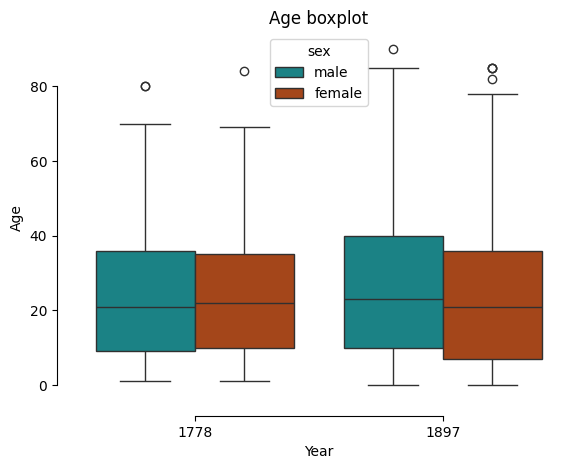

In [87]:
people1_ages_df = people1_df.loc[:, ['age', 'sex']]
people1_ages_df.loc[:, 'year'] = 1897
people1_ages_df.loc[people1_ages_df.sex == 'm', 'sex'] = 'male'
people1_ages_df.loc[people1_ages_df.sex == 'f', 'sex'] = 'female'

people2_ages_df = people2_df.loc[:, ['age', 'sex']]
people2_ages_df.loc[:, 'year'] = 1778
people2_ages_df.loc[people2_ages_df.sex == 'm', 'sex'] = 'male'
people2_ages_df.loc[people2_ages_df.sex == 'f', 'sex'] = 'female'

data_concated_ages = pd.concat([people2_ages_df, people1_ages_df])

plt.title('Age boxplot')
sns.boxplot(
    data=data_concated_ages,
    y='age',
    x='year',
    hue='sex',
    legend='brief',
    palette=['#0a9396', '#bb3e03'],
)
sns.despine(offset=10, trim=True)
plt.xlabel('Year')
plt.ylabel('Age')
plt.show()

In [88]:
mean_age1 = people1_df.age.mean()
mean_age2 = people2_df.age.mean()

people_count1 = people1_df.age.count()
people_count2 = people2_df.age.count()

men_count1 = men_ages_1.count()
men_count2 = men_ages_2.count()

mean_men1 = men_ages_1.mean()
mean_men2 = men_ages_2.mean()

mean_women1 = women_ages_1.mean() * -1
mean_women2 = women_ages_2.mean() * -1

print("Some more statistics in 1778 and 1897 years:")
print(f"The average age - {round(mean_age2, 2)} and {round(mean_age1, 2)}")
print(f"The number of people - {people_count2} and {people_count1}")
print(f"The men proportion - {round(men_count2 / people_count2, 2) * 100}% and {round(men_count1 / people_count1, 2) * 100}%")
print(f"The men average age - {round(mean_men2, 2)} and {round(mean_men1, 2)}")
print(f"The women average age - {round(mean_women2, 2)} and {round(mean_women1, 2)}")

Some more statistics in 1778 and 1897 years:
The average age - 23.53 and 25.42
The number of people - 1597 and 1545
The men proportion - 52.0% and 50.0%
The men average age - 23.58 and 26.63
The women average age - 23.47 and 24.2


### Family Size

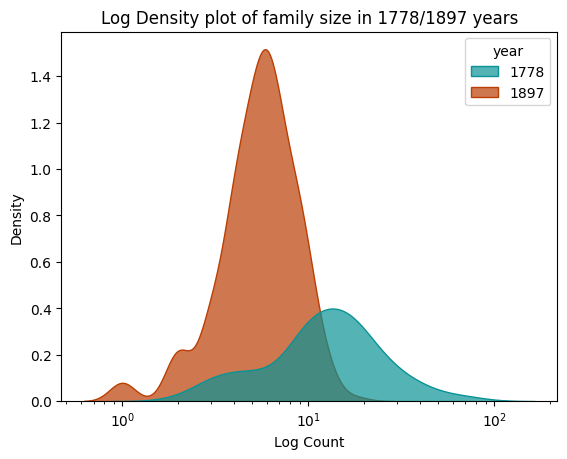

In [89]:
family_size_counts_1 = people1_df.groupby('household_id')['id'] \
    .count() \
    .reset_index() \
    .rename(columns={'id': 'count'}) \
    .sort_values('count')

family_size_counts_1.loc[:, 'year'] = 1897

family_size_counts_2 = people2_df.groupby('household_id')['id'] \
    .count() \
    .reset_index() \
    .rename(columns={'id': 'count'}) \
    .sort_values('count')

family_size_counts_2.loc[:, 'year'] = 1778

family_size = pd.concat([family_size_counts_1, family_size_counts_2])

plt.title('Log Density plot of family size in 1778/1897 years')
ax = sns.kdeplot(
    data=family_size,
    x='count',
    hue='year',
    log_scale=True,
    fill=True,
    alpha=0.7,
    palette=['#0a9396', '#bb3e03']
)
plt.xlabel('Log Count')
plt.show()

In 1778 the family could include even **100 members**, so it is why the blue graph is wide and due to it, it is better to use the log scale

In [90]:
print(f"The average family size in 1778 is {round(family_size_counts_2['count'].mean(), 2)}")
print(f"And the average family size in 1897 is {round(family_size_counts_1['count'].mean(), 2)}")

The average family size in 1778 is 15.21
And the average family size in 1897 is 5.94


### Family Total Structure Comparison

In [92]:
fig = make_subplots(
    rows=2,
    cols=2,
    specs=[[{'type': 'pie'}, {'type': 'pie'}], [{'type': 'bar', 'colspan': 2}, None]],
    subplot_titles=(
        'People category distribution in 1778',
        'People category distribution in 1897',
        'People class distribution in 1778/1897'
    ),
    vertical_spacing=0.15
)

pie_colors = ['#001219', '#0a9396', '#e9d8a6', '#ca6702', '#ae2012']

fig.add_trace(
    go.Pie(
        labels=family_total_structure_1_df.category.unique(),
        values=family_total_structure_1_df.groupby('category')['category_total_count'] \
            .first() \
            .reset_index() \
            ['category_total_count'],
        textinfo='value',
        hoverinfo='label+percent',
        marker=dict(colors=pie_colors, line=dict(color='#000000', width=2)),
        textfont_size=20,
        hole=0.3
    ),
    row=1, col=2
)

fig.add_trace(
    go.Pie(
        labels=family_total_structure_2_df.category.unique(),
        values=family_total_structure_2_df.groupby('category')['category_total_count'] \
            .first() \
            .reset_index() \
            ['category_total_count'],
        textinfo='value',
        hoverinfo='label+percent',
        marker=dict(colors=pie_colors, line=dict(color='#000000', width=2)),
        textfont_size=20,
        hole=0.3
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(
        name='1778',
        x=family_total_structure_2_df.loc[:, 'class'],
        y=family_total_structure_2_df.loc[:, 'class_percentage'] / 100,
        marker_color='#9b2226'
    ),
    row=2, col='all'
)

fig.add_trace(
    go.Bar(
        name='1897',
        x=family_total_structure_1_df.loc[:, 'class'],
        y=family_total_structure_1_df.loc[:, 'class_percentage'] / 100,
        marker_color='#005f73'
    ),
    row=2, col='all'
)

fig.update_yaxes(
    tickformat=".0%",
)

fig.update_traces(textposition='inside')
fig.update_layout(
    barmode='group',
    height=900,
    width=1000,
    uniformtext_minsize=12,
    uniformtext_mode='hide',
)

fig.show()

Family structure in 1778 was very broad and included a large circle of relatives, so about 52% families in 1778 were remarked as "other" class. And to 1897 the number of nuclear, total and expanded families was highly increased  

### Surname Comparison

In [93]:
auth_key = os.getenv('AUTH_KEY')

In [94]:
deepl_client = deepl.DeepLClient(auth_key)

To decrease the number of requests and the time of translating let's translate only the male surname of each household 

In [95]:
surnames_1 = people1_df[people1_df.sex == 'm'] \
    .groupby(['household_id'])['surname'] \
    .first() \
    .reset_index()

surnames_1.loc[:, 'surname_translated'] = ''
surnames_1.loc[:, 'surname_translated'] = surnames_1.surname.apply(lambda x: deepl_client.translate_text(x, target_lang="UK").text)

In [96]:
surnames_2 = people2_df.groupby(['household_id'])['surname'] \
    .first() \
    .reset_index() \
    ['surname']

In [97]:
(len(surnames_1), len(surnames_2))

(256, 105)

In [98]:
surnames_1 = pd.Series(surnames_1['surname_translated'].str.lower())
surnames_2 = surnames_2.str.lower()

In [99]:
# Not include last symbols at the end of the word
surnames_1 = surnames_1.str.extract(r'(\w+)', expand=False)
surnames_2 = surnames_2.str.extract(r'(\w+)', expand=False)

In [100]:
similar_surnames_text = ''

for surname in list(surnames_2):
    if surname in set(surnames_1):
        similar_surnames_text += surname + ' '

Let's see the word cloud of the most similar surnames that there are in both years

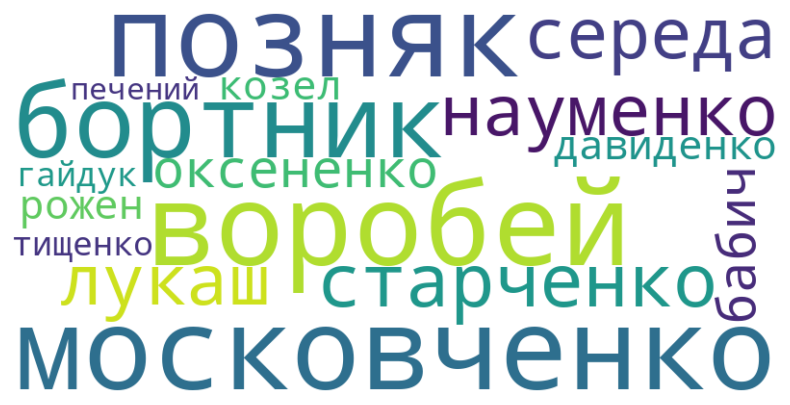

In [101]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(similar_surnames_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

It is *so* sadly to see "московченко" here, but it is the reality 😩

## Conclusions

Using preprocessed data and the listed visualizations we can make the next conclusions:
1) The average age and sex ratio are remained stable ;
2) The sex ratio proportion is almost the same (≈ 1);
3) The family size during the period was highly decreased (from 15 => 6);
4) The percentage of nuclear and expanded families was highly increased (from 19% => 43.5%, and from 1.8% => 20% respectively)
5) The percentage of "other" family class was extremely decreased (from 58% => 2%), and so the percentage of the others classes was increase (particularly for "3b Шлюбні пари з дітьми" and for "5b Родини з низхідними другорядними ядрама")
6) The most common surnames in both years are: Позняк, Московченко, Воробей, Бортник... 